## Jupyter Notebook for converting GCS(EPSG:4326) into PCS(EPSG:3411) 

>1. EPSG:3411 NSIDC Sea Ice Polar Stereographic North 
>2. EPSG:4326 WGS 84
>3.  [Online EPSG Transfer coordinates](<http://epsg.io/transform#s_srs=3411&t_srs=4326>)
>4. **THIS IS A DEMO.**


In [2]:
from pyproj import Proj, transform
from netCDF4 import Dataset
import numpy as np

In [3]:
"Simple test - One point"
inProj = Proj(init='epsg:4326')
outProj = Proj(init='epsg:3411')
x1,y1,z1 = 135.00,39.43,1.0
x2,y2,z2 = transform(inProj,outProj,x1,y1,z1)
print(x2,y2,z2)

7.163649931678661e-10 5849564.083837293 1.0


In [4]:
"Convert coordinate system 2"
'''EPSG 4326 to EPSG 3411'''
def ConCoor(x1,y1,z1):
    inProj = Proj(init='epsg:4326')
    outProj = Proj(init='epsg:3411')
    x2,y2,z2 = transform(inProj,outProj,x1,y1,z1)
#     x2,y2 = transform(inProj,outProj,x1,y1)
    #print(x2,y2)
    return x2,y2,z2
# return x2,y2

In [5]:
"Load Data"
def ReadERA(filename):
    file = Dataset(filename)
    Lon = file.variables['longitude'][:]
    Lat = file.variables['latitude'][:] 
    sic = file.variables['ci'][0][:][:]    # only read the first day
    file.close()
    return sic,Lon,Lat

In [6]:
"Load X and Y"
def ReadXYZ(filename):
    file = Dataset(filename)
    x = file.variables['x'][:]
    y = file.variables['y'][:] 
    z = file.variables['z'][:]
    file.close()
    return x,y,z

In [7]:
if __name__ == '__main__':
    filename = "C:\\Users\\kathy\\research\\Sea-Ice-Concentration\\data\\ERA 5\\20180904-20180906.nc"
    sic0,lon,lat0 = ReadERA(filename)
#     print(np.shape(sic0))
    lat=lat0[lat0>30]
    sic=sic0[lat0>30,:]
    print(np.shape(lon),np.shape(lat),np.shape(sic))
    print(np.min(lat),np.max(lat))
    print(np.min(lon),np.max(lon))
    
    x=np.zeros((240,1440))
    y=np.zeros((240,1440))
    z=np.zeros((240,1440))
    for i in range(len(lat)):
        for j in range(len(lon)):
            x[i,j],y[i,j],z[i,j]=ConCoor(lon[j],lat[i],sic[i,j])
    print(i,j)

(1440,) (240,) (240, 1440)
30.25 90.0
0.0 359.75


C:\Users\kathy\Anaconda3\lib\site-packages\pyproj\__init__.py:517: UserWarning: Warning: converting a masked element to nan.
  return array('d',(float(x),)),True,False,False


239 1439


In [8]:
# Check the accuracy of coordinates transform
i=135
j=180
print(lon[j],lat[i],x[i,j]/1000.0,y[i,j]/1000.0)   # 45.00 56.35 3750km 0
row=np.shape(x)[0]
col=np.shape(x)[1]
print(row,col)    # row,column

45.0 56.25 3761.3722994766717 -2.303176273477813e-13
240 1440


In [9]:
filename = "C:/Users/kathy/research/Sea-ice-concentration/data/UB/sic/asi-AMSR2-n6250-20180905-v5.4.nc"
x2,y2,sic2 = ReadXYZ(filename)

In [12]:
''' griddata'''
from scipy.interpolate import griddata
points = (x,y)
values = np.reshape(z,row*col,1)
grid_x,grid_y = np.meshgrid(x2,y2)
grid_y = y2
grid_z = griddata(points,values,(grid_x,grid_y),method='nearest')

ValueError: different number of values and points

In [24]:
''' Remappping'''
x1=np.zeros((2200,2200))
y1=np.zeros((2200,2200))
map1=np.zeros((2200,2200))
cnt1=np.zeros((2200,2200))
for i in range(row):
    for j in range(col):
        xx=x[i,j]
        yy=y[i,j]
#         r=np.sqrt(x**2+y**2)
        imap=int(np.round(xx/6250.0+616))
        jmap=int(np.round(yy/6250.0+856))
        x1[imap,jmap]=x1[imap,jmap]+xx
        y1[imap,jmap]=x1[imap,jmap]+yy
        map1[imap,jmap]=map1[imap,jmap]+sic[i,j]
        cnt1[imap,jmap]=cnt1[imap,jmap]+1.0
x1=x1/cnt1
y1=y1/cnt1
map1=map1/cnt1

C:\Users\kathy\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Warning: converting a masked element to nan.
  
C:\Users\kathy\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\kathy\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
C:\Users\kathy\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


In [36]:
print(np.mean(sic))
print(np.nanmean(map1))

0.22896347700308226
0.11888865379027204


In [62]:
map2 = map1[0:1792,0:1216]
map2 = map2*100.0

In [16]:
print(np.shape(x),np.shape(y))
# xx=x.T
# yy=y.T

(1440, 240) (1440, 240)


In [46]:
g1 = 1440*240
g2 = 1216*1792
print(g1,g2,g2/g1)

345600 2179072 6.305185185185185


In [59]:
lon_2d,lat_2d=np.meshgrid(lon,lat)
print(np.shape(lon_2d),np.shape(lat_2d))

(240, 1440) (240, 1440)


IndexError: index 1339 is out of bounds for axis 0 with size 240

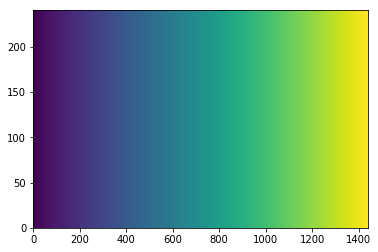

In [55]:
import matplotlib.pyplot as plt
plt.pcolor(lon_2d)
plt.show()

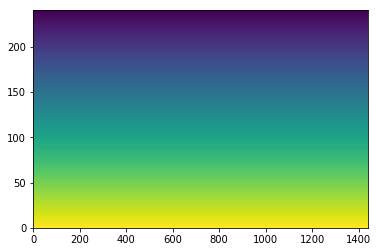

In [56]:
import matplotlib.pyplot as plt
plt.pcolor(lat_2d)
plt.show()

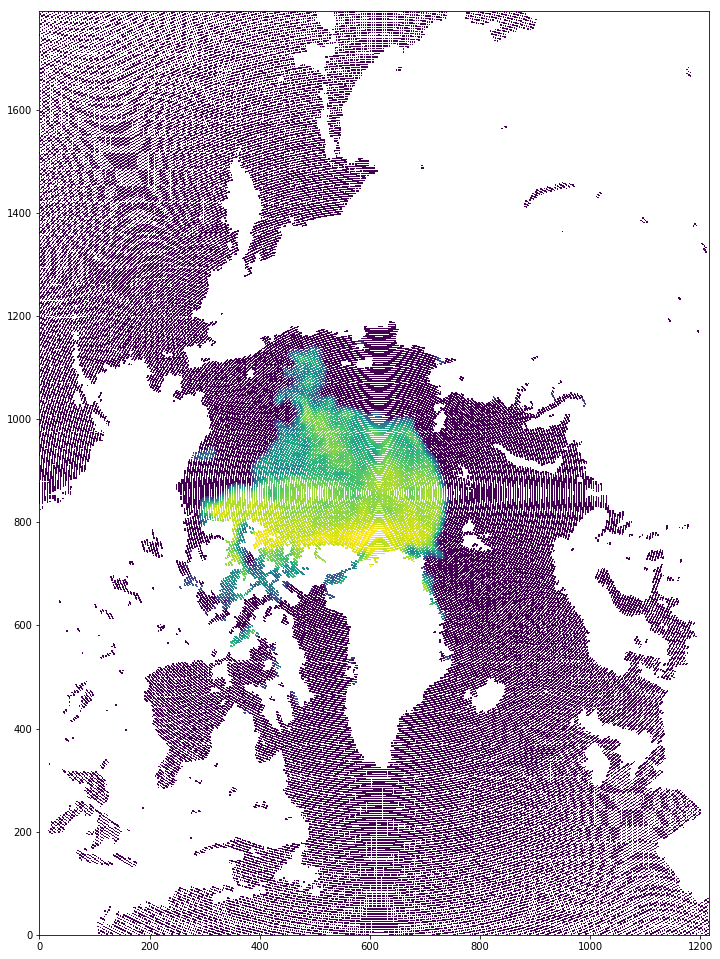

In [47]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(12,17))
plt.pcolormesh(map1[0:1216,0:1792].T)
plt.show()
# plt.colorbar()

In [10]:
import matplotlib.pyplot as plt
plt.pcolor(grid_z)
plt.show()

NameError: name 'grid_z' is not defined